In [1]:
%matplotlib inline
'''
How to Train Your Dragon: V5
Sequentially optimize an already initialized FT reactive distillation process

Capability includes:

Temperature, Reflux, Product Flow Rate, Feed Allocation, Catalyst Allocation and Tray Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-08 19:11:48 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=10,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
#     return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
#             sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
#     return (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total) \
#             == (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma)
    return pe.log(model.scale_epi + (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total))\
            == pe.log(model.scale_epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma))            
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True, scale = True)

In [16]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20                    yes
                    min_refinement_steps = 5                     yes
                                 mu_init = 1e-06                 yes
           mu_super

In [17]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6481  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.8  0.000       0.000  0.000  0.000  0.000       5.7751  0.0000  0.7526  0.0000       20.000
NON--[2]     132.0  0.000       0.000  0.000  0.000  0.000       5.8796  0.0000  0.6828  0.0000       20.000
NON--[3]     141.4  0.000       0.000  0.000  0.000  0.000       5.8098  0.0000  0.6177  0.0023       20.000
NON--[4]     150.0  0.000       0.000  0.000  0.000  

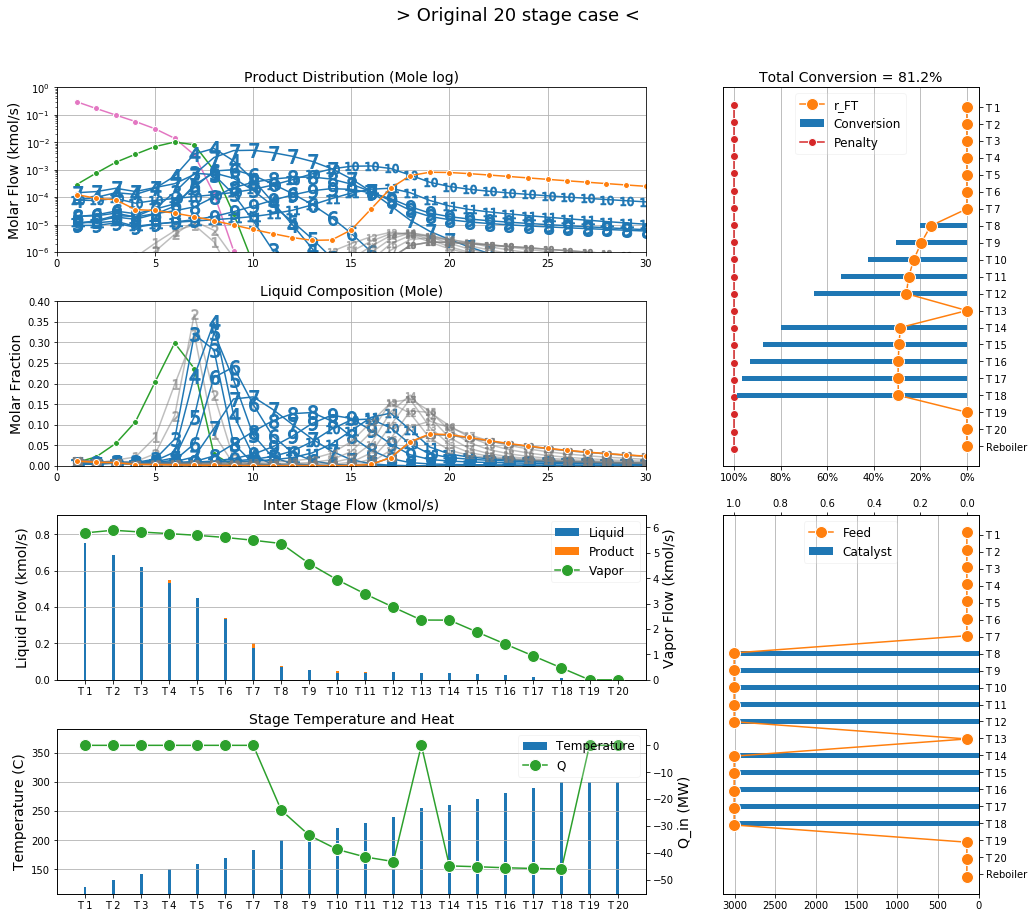

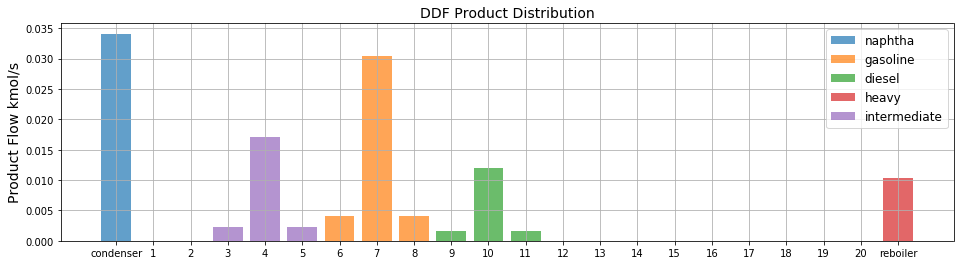

In [18]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [19]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [20]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [21]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [22]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20                    yes
                    min_refinement_steps = 5                     yes
                                 mu_init = 1e-06                 yes
           mu_super

  55 -9.8992454e-02 6.53e+00 2.16e+01  -6.0 5.48e+02    -  4.42e-02 3.10e-01h  1
  56 -9.8945340e-02 4.73e-01 4.03e+01  -6.0 1.66e+02  -8.9 4.07e-02 1.00e+00h  1
  57 -9.9026339e-02 5.71e+00 2.44e+01  -6.0 4.99e+02  -9.4 3.05e-01 9.81e-01h  1
  58 -9.9330500e-02 4.05e+00 9.97e+00  -6.0 5.84e+02  -9.9 8.89e-01 5.61e-01h  1
  59 -1.0019345e-01 1.83e+01 4.07e+01  -6.0 8.42e+02    -  9.86e-02 5.56e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.0051882e-01 1.33e+01 2.83e+01  -6.0 6.17e+02  -9.5 1.47e-01 3.19e-01h  1
  61 -1.0201552e-01 1.37e+01 2.50e+01  -6.0 3.05e+03  -9.9 6.78e-01 6.97e-01H  1
  62 -1.0211270e-01 1.39e+01 2.49e+01  -6.0 7.51e+03    -  3.62e-05 1.35e-02H  1
  63 -1.0219825e-01 1.08e+01 2.09e+01  -6.0 9.03e+02    -  1.00e+00 1.83e-01h  1
  64 -1.0190677e-01 6.82e-01 1.37e+01  -6.0 1.22e+02    -  2.40e-01 1.00e+00h  1
  65 -1.0196734e-01 1.22e-01 1.29e+00  -6.0 7.86e+01  -8.6 8.50e-01 1.00e+00h  1
  66 -1.0203819e-01 1.86e-01


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 88.03%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1386          0.9921  0.0871       2.3285

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.7  0.000       0.000  0.000  0.000  0.000       5.5466  0.0000  1.2312  0.0000       20.000
NON--[2]     149.7  0.000       0.000  0.000  0.000  0.000       5.7857  0.0000  1.1758  0.0000       20.000
NON--[3]     160.9  0.000       0.000  0.000  0.000  0.000       5.7303  0.0000  1.1268  0.0000       20.000
NON--[4]     170.0  0.00

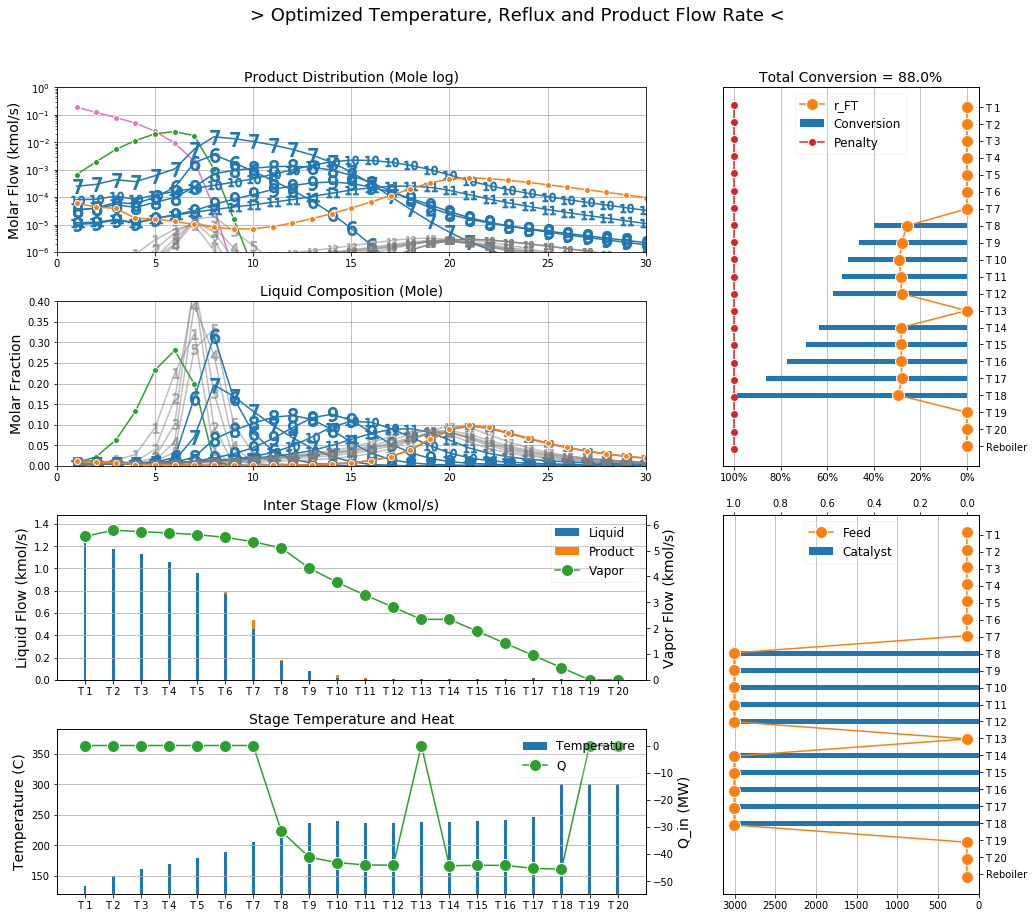

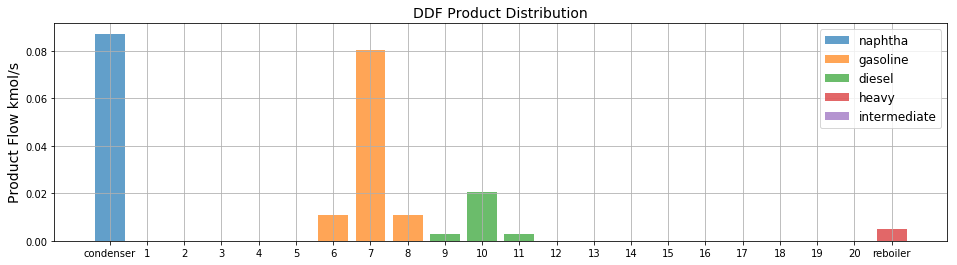

In [23]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [24]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [25]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)
    
# soft constraints to guide the feed allocation pattern
model.reactive[17].F.setlb(3)

In [26]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20                    yes
                    min_refinement_steps = 5                     yes
                                 mu_init = 1e-06                 yes
           mu_super

  55 -1.1852144e-01 1.68e+00 2.11e+03  -6.0 3.31e+02    -  7.56e-01 7.03e-01f  1
  56 -1.1851856e-01 1.18e+00 1.30e+03  -6.0 4.92e+02    -  1.00e+00 2.88e-01h  1
  57 -1.1880350e-01 3.34e+00 1.42e+02  -6.0 3.02e+02    -  1.41e-01 1.00e+00h  1
  58 -1.1906734e-01 1.67e+00 5.79e+01  -6.0 3.72e+02    -  1.07e-01 1.00e+00h  1
  59 -1.1903288e-01 1.81e-04 3.97e+01  -6.0 1.19e+00  -5.8 4.08e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.1918376e-01 5.88e-01 2.29e+01  -6.0 9.68e+02    -  4.32e-01 2.27e-01h  2
  61 -1.1956366e-01 3.16e+00 7.10e+01  -6.0 7.98e+02    -  1.00e+00 5.00e-01H  1
  62 -1.1996735e-01 1.48e+01 2.10e+01  -6.0 1.09e+03    -  4.37e-01 1.00e+00h  1
  63 -1.1992661e-01 2.91e-03 3.25e+00  -6.0 3.56e+00  -6.3 1.00e+00 1.00e+00h  1
  64 -1.2016403e-01 7.14e+00 2.78e+01  -6.0 3.92e+03    -  1.61e-01 1.89e-01h  2
  65 -1.2041495e-01 1.63e+01 4.81e+01  -6.0 3.42e+03    -  6.61e-01 2.65e-01h  2
  66 -1.2068000e-01 2.00e+01


> Optimized Feed Allocation
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.50%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -149.                                        1.8411          0.6318  0.0962       2.4205

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     125.4  0.000       0.000  0.000  0.000  0.000       4.9897  0.0000  0.7452  0.0000       20.000
NON--[2]     135.1  0.000       0.000  0.000  0.000  0.000       5.1031  0.0000  0.6909  0.0000       20.000
NON--[3]     142.8  0.000       0.000  0.000  0.000  0.000       5.0488  0.0000  0.6504  0.0000       20.000
NON--[4]     149.8  0.000       0.000  0.000  0.00

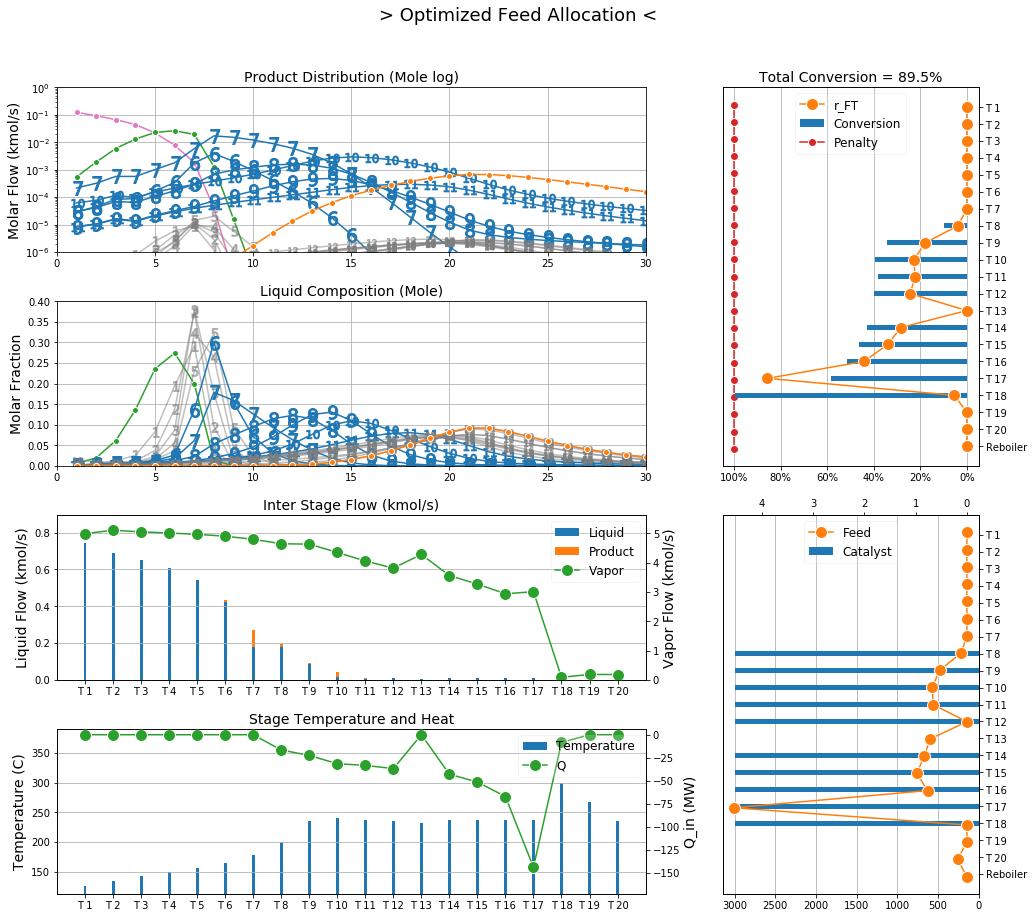

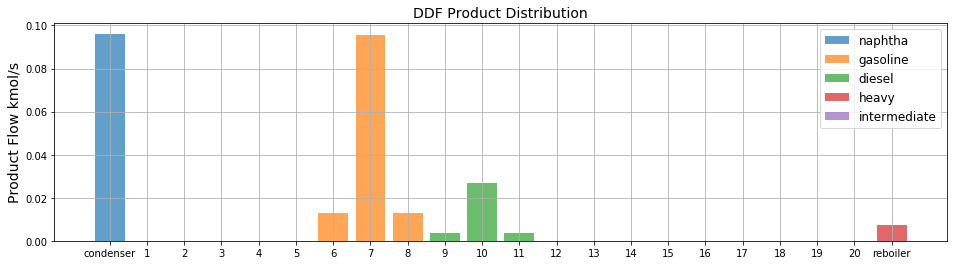

In [27]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Allocation')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Feed Allocation')
plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [28]:
for j in model.TRAY_reactive:
    model.reactive[j].cat.unfix()
    model.reactive[j].cat.setlb(10)
    model.reactive[j].cat.setub(30000)

In [29]:
model.total_cat_con = pe.ConstraintList()
model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [30]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20                    yes
                    min_refinement_steps = 5                     yes
                                 mu_init = 1e-06                 yes
           mu_super

  55 -1.2691588e-01 6.68e+00 1.40e+04  -6.0 4.23e+01  -7.4 3.36e-02 1.00e+00h  1
  56 -1.2745193e-01 7.63e+00 1.28e+04  -6.0 1.06e+03  -7.8 1.15e-01 7.08e-02h  1
  57 -1.2673539e-01 2.40e+00 4.38e+03  -6.0 2.22e+02  -8.3 3.14e-02 6.92e-01H  1
  58 -1.2681300e-01 6.89e-02 5.71e+02  -6.0 1.71e+00  -5.2 7.81e-01 1.00e+00h  1
  59 -1.2683351e-01 7.75e-02 1.09e+02  -6.0 3.43e+00  -5.7 1.00e+00 2.49e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.2688912e-01 1.99e-01 7.91e+01  -6.0 1.13e+01  -6.1 1.00e+00 3.27e-01f  1
  61 -1.2720467e-01 3.59e+00 5.32e+01  -6.0 9.46e+01  -6.6 2.13e-01 2.91e-01h  1
  62 -1.2745176e-01 1.06e+01 3.93e+01  -6.0 5.37e+01  -7.1 4.01e-01 2.47e-01h  1
  63 -1.2788606e-01 2.16e+01 2.36e+01  -6.0 4.68e+01  -7.6 3.79e-02 3.30e-01h  1
  64 -1.2787469e-01 1.71e+01 1.85e+01  -6.0 1.54e+01  -8.0 3.06e-01 2.43e-01h  1
  65 -1.2796593e-01 1.15e+01 1.52e+01  -6.0 3.86e+01  -8.5 1.00e+00 3.60e-01h  1
  66 -1.2800465e-01 5.65e-02


> Optimized Catalyst Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 90.04%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -151.                                        1.7220          0.6137  0.0980       2.4710

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     125.8  0.000       0.000  0.000  0.000  0.000       4.9047  0.0000  0.7246  0.0000       20.000
NON--[2]     135.2  0.000       0.000  0.000  0.000  0.000       5.0157  0.0000  0.6709  0.0000       20.000
NON--[3]     142.8  0.000       0.000  0.000  0.000  0.000       4.9620  0.0000  0.6311  0.0000       20.000
NON--[4]     149.7  0.000       0.000

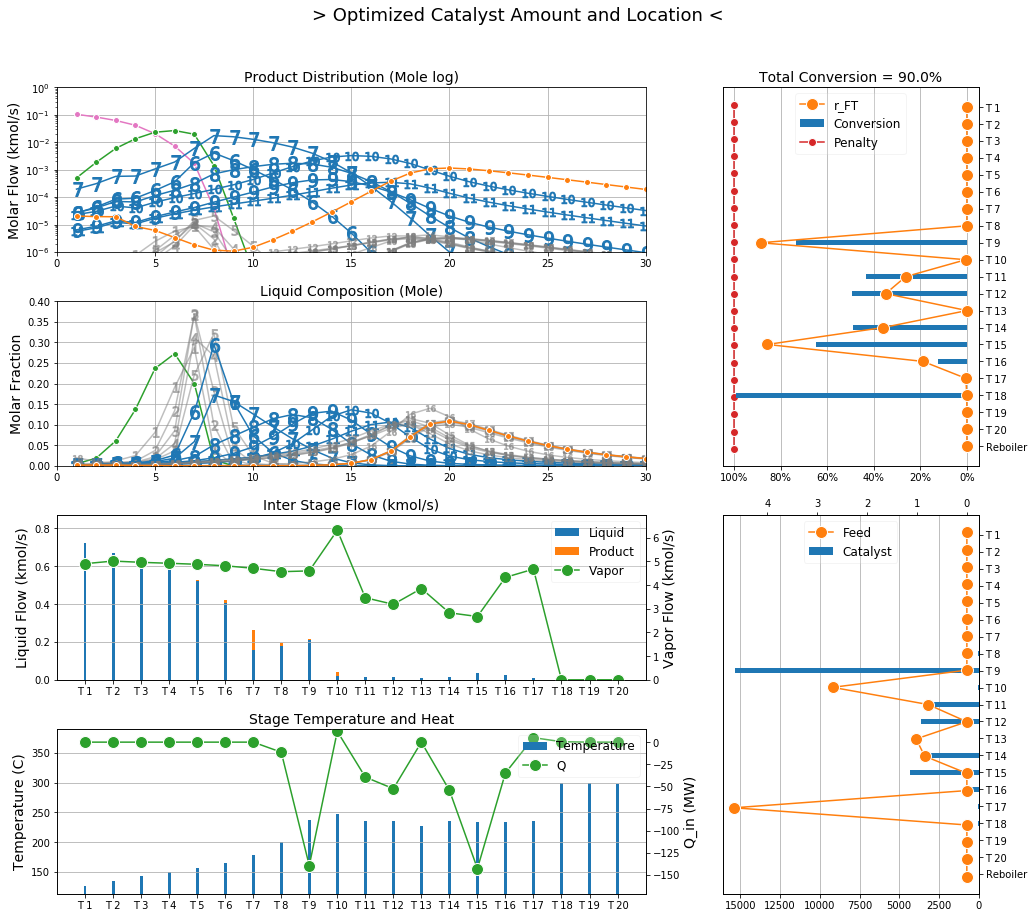

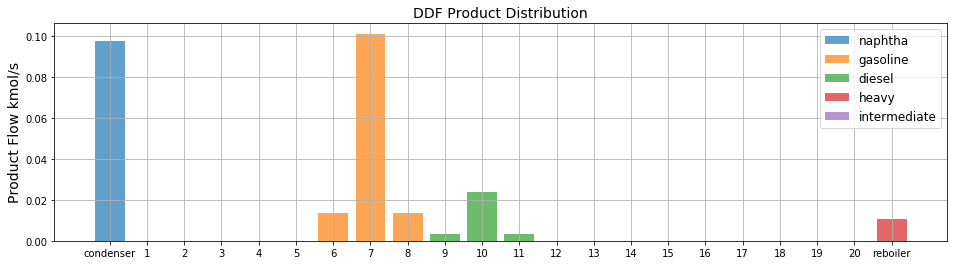

In [31]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Catalyst Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [32]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [33]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20                    yes
                    min_refinement_steps = 5                     yes
                                 mu_init = 1e-06                 yes
           mu_super

  55 -1.3048270e-01 2.15e-01 1.18e+00  -6.0 1.09e+01  -8.2 8.87e-01 1.00e+00h  1
  56 -1.3048177e-01 3.03e-01 6.08e+00  -6.0 4.35e+01  -8.7 3.36e-01 9.41e-02h  2
  57 -1.3047726e-01 3.25e-01 3.43e+00  -6.0 8.26e+01  -9.1 1.00e+00 3.66e-01h  2
  58 -1.3046964e-01 1.20e+00 2.91e-01  -6.0 2.70e+02  -9.6 1.00e+00 1.00e+00h  1
  59 -1.3047289e-01 3.35e+00 1.46e+01  -6.0 9.46e+02 -10.1 8.52e-01 4.28e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.3047062e-01 3.67e+00 8.30e+01  -6.0 7.93e+03    -  1.64e-01 1.97e-02h  1
  61 -1.3046190e-01 5.52e+00 1.88e+02  -6.0 1.26e+04    -  1.74e-01 2.78e-02h  1
  62 -1.3042310e-01 3.54e+01 9.12e+01  -6.0 2.36e+03 -10.6 1.00e+00 6.18e-01f  1
  63 -1.3041852e-01 3.23e+01 1.12e+02  -6.0 1.60e+03    -  6.35e-02 9.57e-02h  1
  64 -1.3040097e-01 2.17e+01 7.38e+02  -6.0 7.89e+02    -  6.39e-02 3.63e-01h  1
  65 -1.3035443e-01 1.60e+01 5.57e+02  -6.0 3.33e+03    -  2.25e-03 2.15e-01H  1
  66 -1.3032084e-01 1.33e+01


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.71%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -147.                                        1.7678          0.5619  0.0922       2.4486

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     123.1  0.000       0.000  0.000  0.000  0.000       4.8706  0.0000  0.6511  0.0000       20.000
NON--[2]     131.7  0.000       0.000  0.000  0.000  0.000       4.9599  0.0000  0.5929  0.0000       20.000
NON--[3]     139.5  0.000       0.000  0.000  0.000  0.000       4.9016  0.0000  0.5434  0.0000       20.000
NON--[4]     147.5  0.000       0.000  0.000  0.

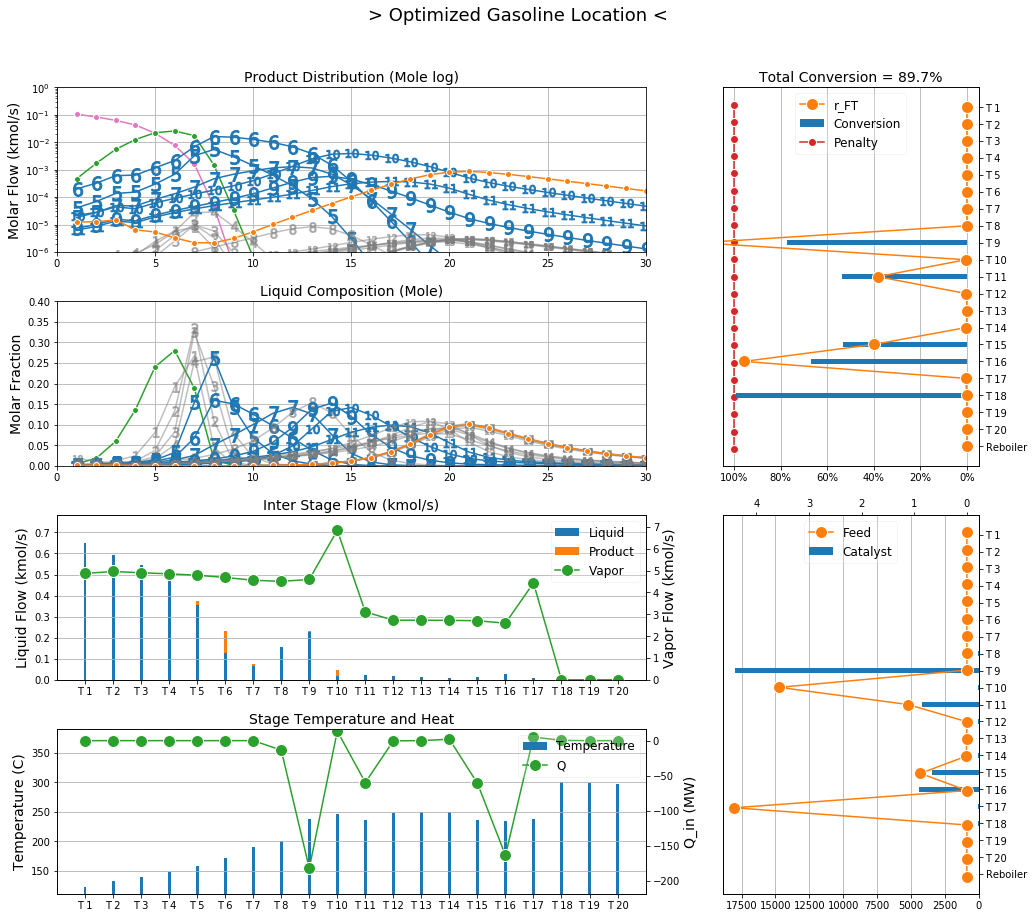

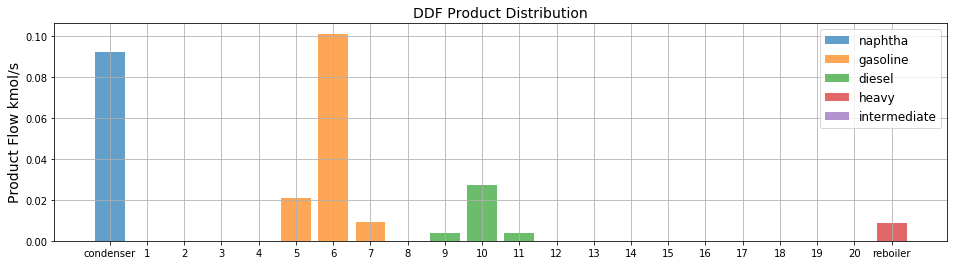

In [34]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Gasoline Location')
plot_product_distribution(model,pdf)

In [35]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(7)
model.N_tray['diesel'].setub(19)

In [36]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                              ma86_small = 1e-30                 yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20                    yes
                    min_refinement_steps = 5                     yes
                                 mu_init = 1e-06                 yes
           mu_super

  55 -1.3389103e-01 4.61e-02 6.80e-01  -6.0 1.27e+01  -7.9 1.00e+00 1.00e+00f  1
  56 -1.3392280e-01 1.59e-01 1.20e+00  -6.0 4.77e+01  -8.4 1.00e+00 1.00e+00h  1
  57 -1.3401623e-01 7.84e-01 6.30e+00  -6.0 9.08e+01  -8.9 1.00e+00 1.00e+00h  1
  58 -1.3423532e-01 1.82e+00 8.99e+00  -6.0 2.66e+03    -  3.49e-01 3.28e-01h  1
  59 -1.3428375e-01 2.92e+00 3.57e+02  -6.0 6.59e+01  -8.4 2.06e-01 8.83e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.3444447e-01 4.45e+00 2.63e+02  -6.0 4.48e+02  -8.9 2.56e-01 2.64e-01h  1
  61 -1.3438545e-01 4.70e-01 2.57e+00  -6.0 1.46e+02  -9.4 1.00e+00 1.00e+00h  1
  62 -1.3453655e-01 2.10e+00 7.71e+00  -6.0 3.11e+02  -9.0 2.85e-01 2.98e-01h  1
  63 -1.3467580e-01 5.82e+00 1.89e+01  -6.0 2.40e+02  -9.4 8.23e-01 8.47e-01h  1
  64 -1.3481087e-01 4.38e+00 1.70e+02  -6.0 5.37e+02  -9.9 4.22e-01 3.13e-01h  1
  65 -1.3480952e-01 4.05e+00 4.35e+02  -6.0 1.61e+03 -10.4 1.73e-01 8.17e-02h  1
  66 -1.3484557e-01 3.83e+00

 148 -1.3998137e-01 5.74e+00 2.24e+03  -7.5 4.72e+01  -6.8 2.33e-02 2.55e-02f  1
 149 -1.3998244e-01 5.58e+00 2.35e+03  -7.5 5.85e+01  -7.3 2.53e-02 2.87e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -1.3998197e-01 3.80e+00 2.20e+03  -7.5 6.94e+00  -7.7 8.71e-01 3.19e-01h  1
 151 -1.3999179e-01 2.45e-01 1.30e+03  -7.5 1.85e+01  -8.2 4.22e-01 9.36e-01h  1
 152 -1.3999131e-01 4.59e-02 1.86e+00  -7.5 1.77e+01  -8.7 1.00e+00 1.00e+00h  1
 153 -1.3999183e-01 2.67e-01 1.85e+00  -7.5 6.40e+03    -  3.23e-02 7.13e-03h  2
 154 -1.3999193e-01 1.92e-01 1.41e+01  -7.5 1.12e+01  -8.3 1.76e-01 2.87e-01h  2
 155 -1.3999208e-01 8.66e-02 1.10e+01  -7.5 1.72e+00  -7.9 1.00e+00 5.48e-01h  1
 156 -1.3999277e-01 5.25e-03 6.34e+00  -7.5 7.38e+00  -8.3 7.39e-01 1.00e+00h  1
 157 -1.3999273e-01 3.17e-03 3.26e+02  -7.5 4.03e+00  -7.0 2.03e-01 5.21e-01h  1
 158 -1.3999317e-01 1.50e-03 1.72e+02  -7.5 6.02e-01  -6.6 1.00e+00 5.31e-01f  1
 159 -1.3999283e-01 6.47e-05


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 90.00%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -149.                                        1.7258          0.6052  0.0819       2.4668

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.5  0.000       0.000  0.000  0.000  0.000       4.8799  0.0000  0.6993  0.0000       20.000
NON--[2]     131.0  0.000       0.000  0.000  0.000  0.000       4.9740  0.0000  0.6289  0.0000       20.000
NON--[3]     140.0  0.000       0.000  0.000  0.000  0.000       4.9036  0.0000  0.5578  0.0000       20.000
NON--[4]     150.7  0.000       0.000  0.000  0.00

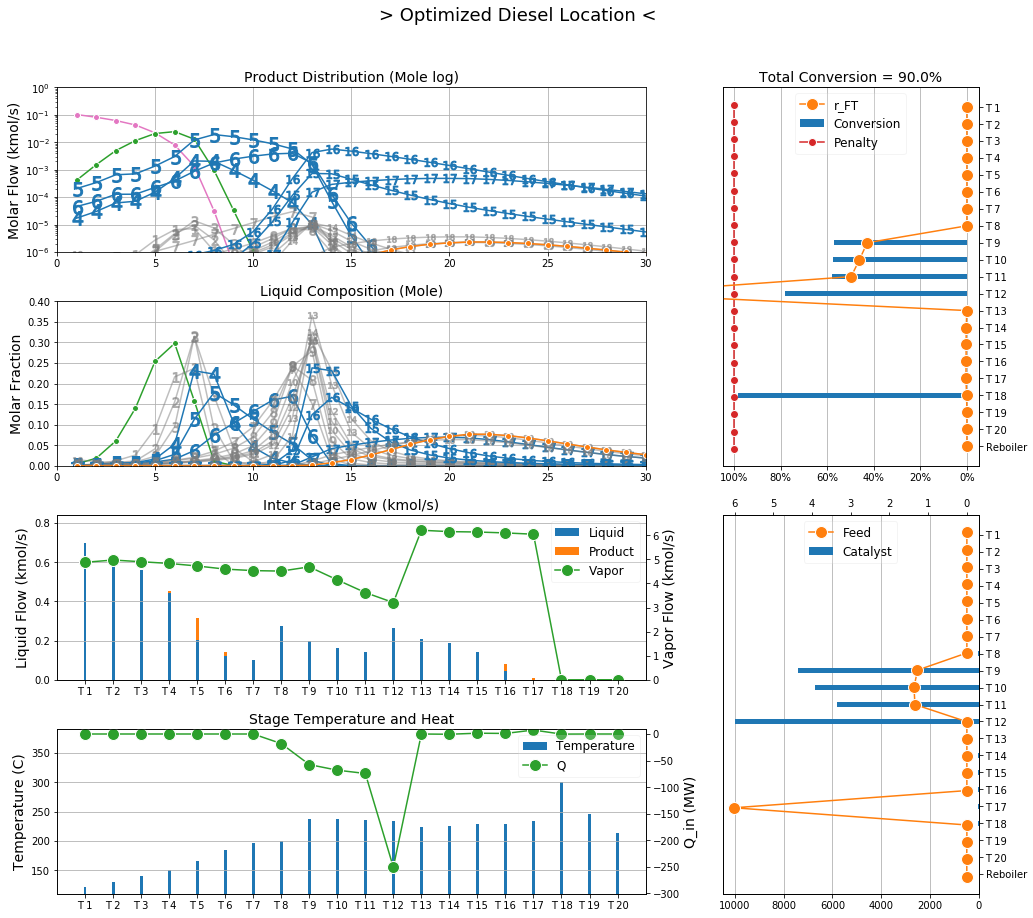

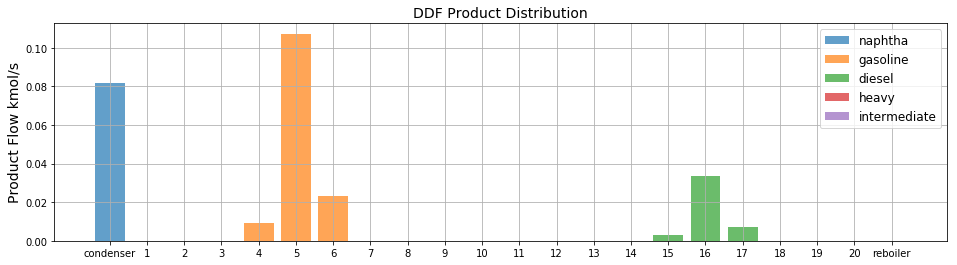

In [37]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

In [38]:
pdf.close()

In [39]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)